# Load Model's Weight from GitHub Repository
- Use GitHub Repository instead of Google Drive for an easier version control and access,
- Model's Weight still available through Google Drive.

# Initializations and Import Libraries

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_advanced_segmentation_models as tasm

from tensorflow import keras

# Model Constants
- Load the Model's Weight File

In [3]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
N_CLASSES = 2
HEIGHT = 320
WIDTH = 320
BACKBONE_NAME = "efficientnetb0"
WEIGHTS = "imagenet"

In [4]:
base_model, layers, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=HEIGHT, width=WIDTH, include_top=False, pooling=None)

BACKBONE_TRAINABLE = False 
model = tasm.DeepLabV3plus(n_classes=N_CLASSES, base_model=base_model, output_layers=layers, backbone_trainable=BACKBONE_TRAINABLE)

Metal device set to: Apple M1


2023-05-24 15:43:10.555788: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-24 15:43:10.556021: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


16705208/16705208 [==============================] - 615s 37us/step


In [5]:
import os
os.getcwd()

'/Users/rabbanikumoro/tensorflow-test/Penglihatan Komputer dan Analisis Citra'

In [6]:
model.load_weights('/Users/rabbanikumoro/tensorflow-test/Penglihatan Komputer dan Analisis Citra/fire-segmentation/weights/DeepLabV3plus-Fire-Segmentation')

In [7]:
model.load_weights('/Users/rabbanikumoro/tensorflow-test/Penglihatan Komputer dan Analisis Citra/fire-segmentation/weights/DeepLabV3plus-Fire-Segmentation')

# Visualize the Mask and Display the Image

In [8]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = tf.cast(pred_mask, tf.float32)
    return pred_mask[0]

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])

        # Convert mask to grayscale
        if i == 1 or i == 2:
            mask = np.array(display_list[i])
            mask = np.squeeze(mask, axis=-1)
            plt.imshow(mask, cmap='gray')
        else:
            plt.imshow(display_list[i])

        plt.axis('off')
    plt.show()

# Image Pre-Processing and Segmentation

In [10]:
def preprocess_image(image):
    # Convert image from RGB to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # Apply histogram equalization to the V channel of the HSV image
    hsv_image[:, :, 2] = cv2.equalizeHist(hsv_image[:, :, 2])
    # Perform median filtering on the V channel
    filtered_image = cv2.medianBlur(hsv_image[:, :, 2], 5)
    # Convert the HSV image back to RGB color space
    processed_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return processed_image, filtered_image


def extract_flames_rgb(image):
    # Extract flames based on pixel distribution rules in RGB color space
    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    flames_rgb = np.logical_and(red_channel > green_channel, red_channel > 177)
    return flames_rgb


def extract_flames_ycbcr(image):
    # Convert RGB image to YCbCr color space
    ycbcr_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    # Extract flames based on pixel distribution rules in YCbCr color space
    y_channel = ycbcr_image[:, :, 0]
    cb_channel = ycbcr_image[:, :, 1]
    cr_channel = ycbcr_image[:, :, 2]
    cb_threshold = np.percentile(cb_channel, 45)
    cr_threshold = np.percentile(cr_channel, 70)
    flames_ycbcr = np.logical_and.reduce([
        y_channel > 75,
        cb_channel < cb_threshold,
        cr_channel > cr_threshold
    ])
    return flames_ycbcr


def apply_and_operator(flames_rgb, flames_ycbcr):
    # Apply 'and' operator to obtain a complete flame image
    flames = np.logical_and(flames_rgb, flames_ycbcr)
    return flames


def apply_or_operator(flames_rgb, flames_ycbcr):
    # Apply 'and' operator to obtain a complete flame image
    flames = np.logical_or(flames_rgb, flames_ycbcr)
    return flames


# Load the original flame image
def segment_img(img):
    THRESHOLD = 0.8
    processed_image, filtered_image = preprocess_image(np.asarray(img))
    flames_rgb = extract_flames_rgb(processed_image)
    flames_ycbcr = extract_flames_ycbcr(processed_image)
    flames = apply_and_operator(flames_rgb, flames_ycbcr)
    flamesImg = tf.keras.preprocessing.image.array_to_img(
        (flames.astype(np.uint8) * 255)[:, :, np.newaxis])
    mask = create_mask(
        model.predict(np.asarray(img)[tf.newaxis, ...])
    )
    filtered = (flames.astype(np.uint8) * 255)[:, :, np.newaxis]
    seg = apply_and_operator(filtered, mask)
    return seg

# Predict and Show the Result

1/1 [==============================] - 0s 50ms/step


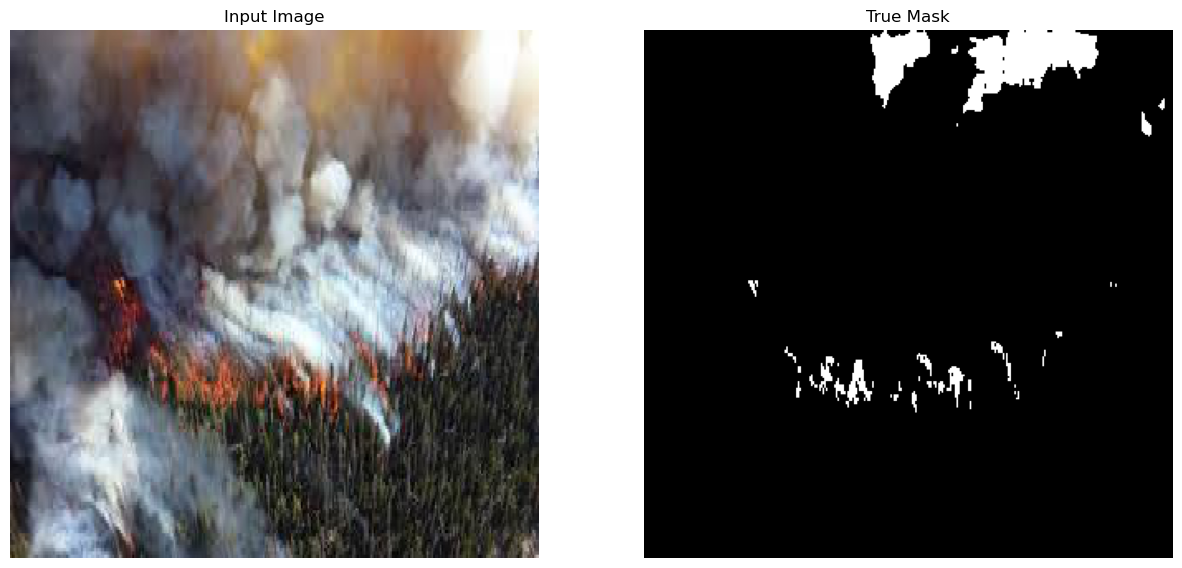

1/1 [==============================] - 0s 50ms/step


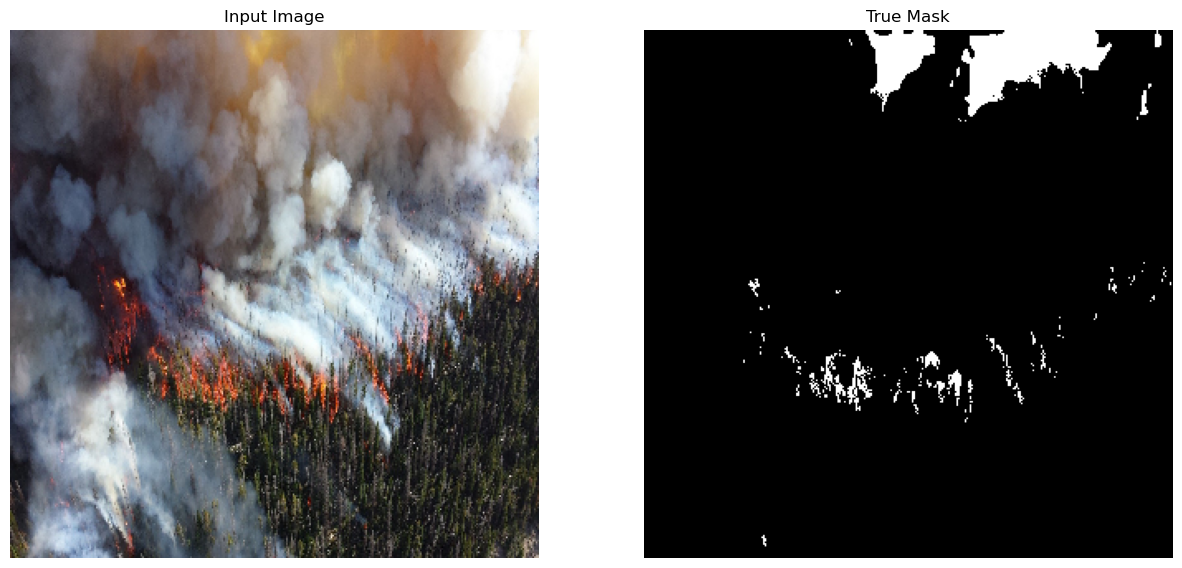

1/1 [==============================] - 0s 57ms/step


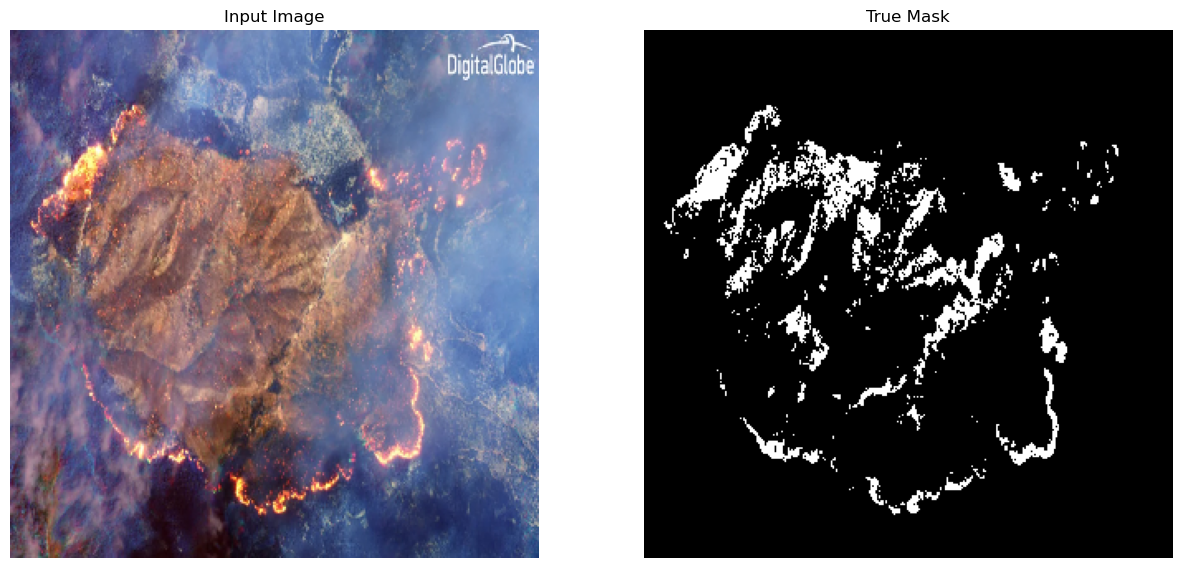

1/1 [==============================] - 0s 54ms/step


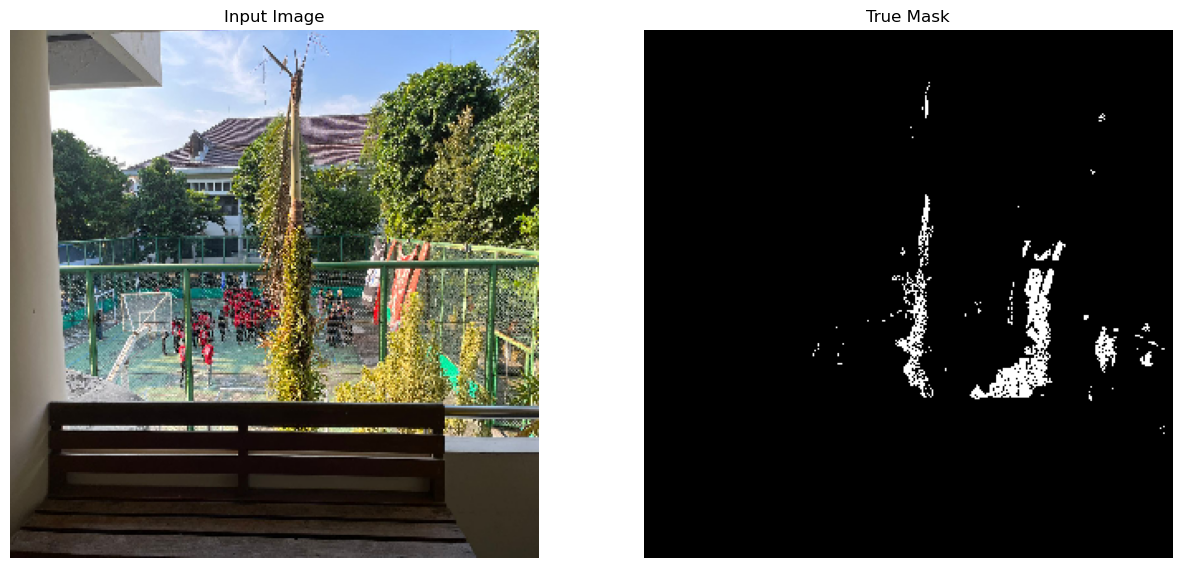

In [15]:
test_img = []
test_img.append(tf.keras.preprocessing.image.load_img('./burik fire.jpeg', target_size=[HEIGHT,WIDTH]))
test_img.append(tf.keras.preprocessing.image.load_img('./gaming fire.jpeg', target_size=[HEIGHT,WIDTH]))
test_img.append(tf.keras.preprocessing.image.load_img('./140903-fire.jpg', target_size=[HEIGHT,WIDTH]))
test_img.append(tf.keras.preprocessing.image.load_img('./wiusod.jpeg', target_size=[HEIGHT,WIDTH]))


for img in test_img:
    display([img, segment_img(img)])